In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import json
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import random
import mrcnn.model as modellib
import mrcnn.visualize as visualize
import mrcnn.config as config
import mrcnn.utils as utils

import warnings
warnings.filterwarnings("ignore")

In [4]:
class FacesConfig(config.Config):
    NAME = "Faces"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    NUM_CLASSES = 4

    LEARNING_RATE = 0.001
    STEPS_PER_EPOCH = 500
    

In [5]:
Faces_config = FacesConfig()

In [6]:
Faces_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [7]:
class FacesDataset(utils.Dataset):
    """Dataset class for faces dataset"""
    
    def __init__(self, images_list, annotations_path, dataset_dir):
        super().__init__(self)
        
        # Add classes
        self.add_class('Faces', 1, 'face')
        self.add_class('Faces', 2, 'nose')
        self.add_class('Faces', 3, 'mouth')
        self.images_data = self.load_images_data(annotations_path) ## RENAME TO ANNOTATIONS

        # Add images
        
        for i, filename in enumerate(images_list):
            images = self.images_data['images']
            for img in images:
                if img['file_name'] == filename:
                    img_id = img['id']
                    fp = os.path.join(dataset_path, filename)
                    img_h = img['height']
                    img_w = img['width']
                    self.add_image('Faces',
                                   image_id=img_id,
                                   path=fp,
                                   height=img_h,
                                   width=img_w)
                    
        self.add_annotations()

        
    def image_reference(self, image_id):
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']
        return None
    
    
    def load_images_data(self, filepath):
        """JSON format annotations"""
        with open (filepath) as file:
            info = json.load(file)
        
        return info
    
    
    def add_annotations(self):
        for i,image in enumerate(self.image_info):
            img_id = image['id']
            segments = [] 
            cat_ids = []
            for img_ann in self.images_data['annotations']:
                if img_id == img_ann['image_id']:
                    segments.append(img_ann['segmentation'][0])
                    cat_ids.append(img_ann['category_id'])
            self.image_info[i]['cat_ids'] = cat_ids
            self.image_info[i]['segments'] = segments
            
        
    def load_mask(self, image_id):
        assert image_id in self.image_ids, 'id not valid'
        
        info = self.image_info[image_id]
        h = info['height']
        w = info['width']
        count = len(info['cat_ids'])
        
        class_ids = np.zeros((count,), dtype=np.int32)
        mask = np.zeros((h,w, count), dtype=np.uint8)
                
        for i, s in enumerate(info['segments']):
            class_ids[i] = info['cat_ids'][i]
            x_s = s[::2]
            y_s = s[1::2]
            rr, cc = skimage.draw.polygon(y_s, x_s)

            mask[rr,cc,i] = 1
        
        return mask, class_ids
        
        
        """
        for img in self.image_info:
            if img['id'] == image_id:
                h = img['height']
                w = img['width']
                count = len(img['cat_ids'])
        
                class_ids = np.zeros((count,), dtype=np.int32)
                mask = np.zeros((h,w, count), dtype=np.uint8)
                
                for i, s in enumerate(img['segments']):
                    class_ids[i] = img['cat_ids'][i]
                    x_s = s[::2]
                    y_s = s[1::2]
                    rr, cc = skimage.draw.polygon(y_s, x_s)

                    mask[rr,cc,i] = 1
        
                return mask, class_ids
          """

    ## only work with masks for now, do not annotate further until first round of training and testing

In [16]:
annots_path = os.path.abspath('./annots/polygons_100.json')
dataset_path = os.path.abspath('./images/labeled')
coco_weights_path = os.path.abspath('./mask_rcnn_coco.h5')
model_path = os.path.abspath('./models')

In [17]:
images_list = os.listdir(dataset_path)
random.seed(12)
random.shuffle(images_list)
val_size = 30
images_val = images_list[:val_size]
images_train = images_list[val_size:]
print(len(images_train), len(images_val))

70 30


In [18]:
# Training set
dataset_train = FacesDataset(images_train, annots_path, dataset_path)
dataset_train.prepare()
print('Train %d' % len(dataset_train.image_ids))

Train 69


In [19]:
# Validation set
dataset_val = FacesDataset(images_val, annots_path, dataset_path)
dataset_val.prepare()
print('Test %d' % len(dataset_val.image_ids))

Test 29


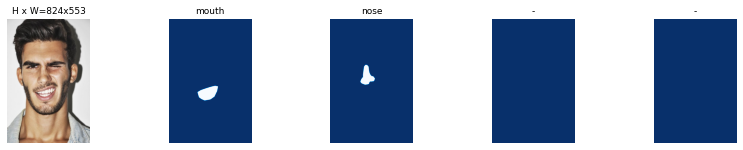

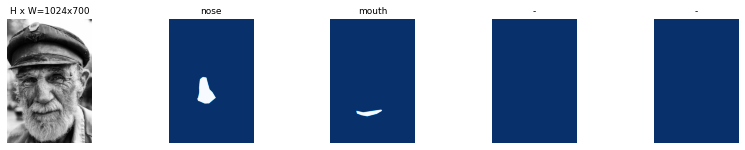

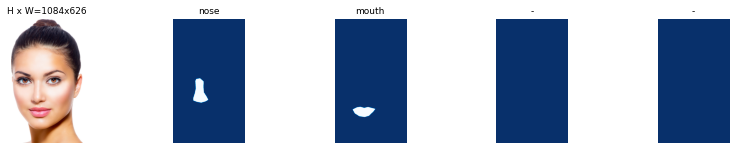

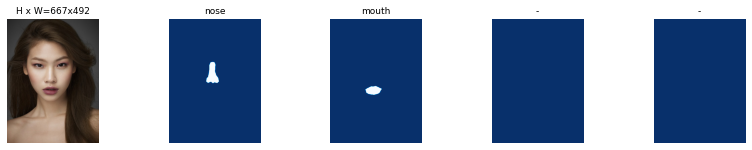

In [20]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids,4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
model = modellib.MaskRCNN(mode='training',
                          config=Faces_config,
                          model_dir=model_path)

In [22]:
model.load_weights(filepath=coco_weights_path, by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=Faces_config.LEARNING_RATE,
            epochs=5,
            layers='heads')

In [94]:
model.train(dataset_train, dataset_val,
            learning_rate=Faces_config.LEARNING_RATE,
            epochs=10,
            layers='all')


Starting at epoch 5. LR=0.001

Checkpoint Path: /content/drive/MyDrive/FaceDetect/models/faces20220829T2146/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D

In [21]:
class FacesInferConfig(config.Config):

    NAME = "Faces"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    NUM_CLASSES = 4

    LEARNING_RATE = 0.001
    STEPS_PER_EPOCH = 500

In [22]:
Infer_config = FacesInferConfig()

In [23]:
model_infer = modellib.MaskRCNN(mode='inference', model_dir=model_path, config=Infer_config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [24]:
weights_path = os.path.abspath('./models/faces20220829T2146/mask_rcnn_faces_0009.h5')
model_infer.load_weights(weights_path, by_name=True)

Re-starting from epoch 9


In [36]:
def get_ax(rows=1, cols=1, size=12):
  _, ax  = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [37]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset_val, Infer_config, image_id, use_mini_mask=True)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info['source'], info['id'], image_id,
                                        dataset_val.image_reference(image_id)))

output = model_infer.detect([image], verbose=1)
results = output[0]
print("Dictionary Keys", results.keys(), end='\n\n')
print("Bounding Boxes:\n", results['rois'], end='\n\n')
print("Class IDs:\n", np.array(dataset_val.class_names)[results['class_ids']], end="\n\n")
print("Prediction Scores:\n", results['scores'], end="\n\n")

image ID: Faces.6 (13) E:\PersonalProjects\FaceDetect\images\labeled\image_3.jpeg
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
Dictionary Keys dict_keys(['rois', 'class_ids', 'scores', 'masks'])

Bounding Boxes:
 [[104 112 166 151]
 [185 102 202 160]]

Class IDs:
 ['nose' 'mouth']

Prediction Scores:
 [0.999895  0.9996686]



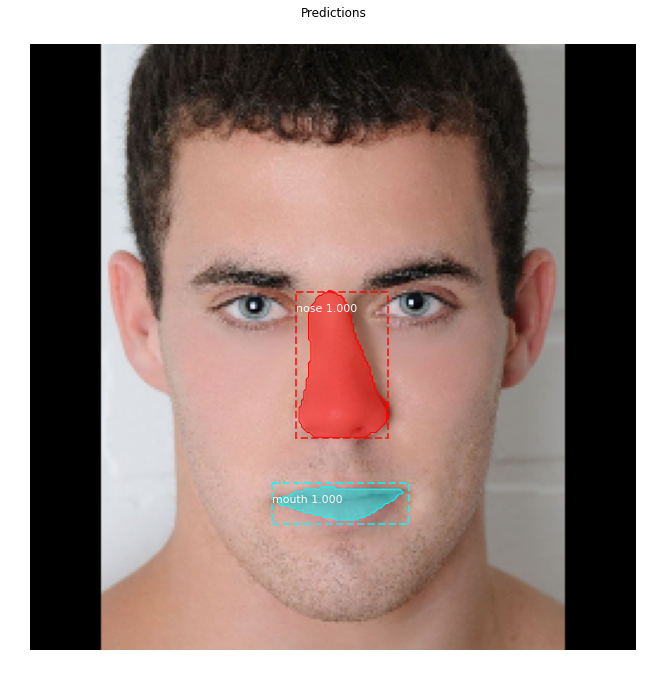

In [38]:
ax = get_ax(1)
r = results

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=ax,
                            title = 'Predictions')

In [39]:
from matplotlib import image

In [40]:
img_path = 'images/Me.jpg'
img = image.imread(img_path)
pred = model_infer.detect([img], verbose=1)

Processing 1 images
image                    shape: (2316, 2316, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -120.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2316.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


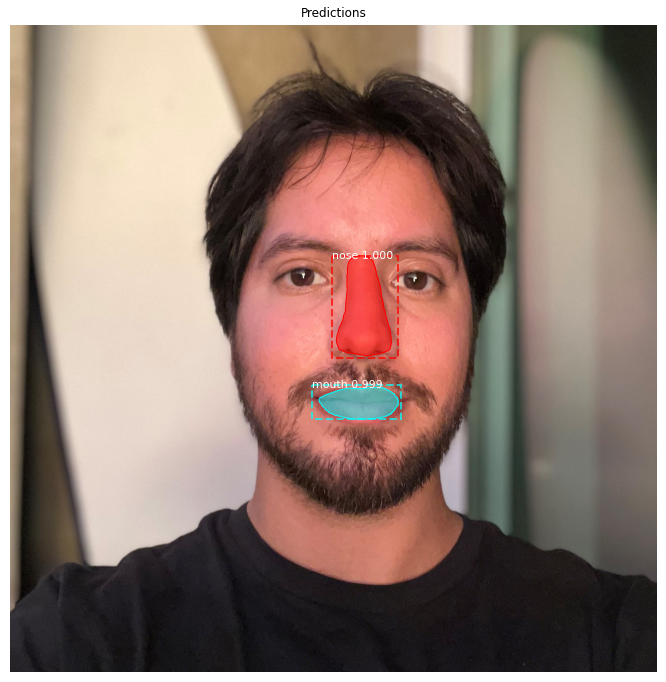

In [41]:
ax = get_ax(1)
r = pred[0]

visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=ax,
                            title = 'Predictions')